In [1]:
using Graphs, GraphIO, GraphPlot, NetworkDynamics, OrdinaryDiffEq, Plots, Graphs, Printf


#f=open("net_celegans_neural.dat")




In [2]:
using LinearAlgebra, IterativeSolvers, Statistics

function get_levels(A)
    
    A= convert(Array{Float64}, A)
    
    w_in = vec(sum(A, dims=1))
   
    w_out= vec(sum(A, dims=2))
    
   
    
    u = w_in + w_out 
    
    v= w_in - w_out 
   
    Lambda=  diagm(u)-  A - transpose(A)
    
   
    Lambda[1,1]= 0 
    
    #h= bicgstabl(Lambda, v, 10)
    h=  lsmr(Lambda, v)   
       
    h= h .- minimum(h)
    
    return h
end

get_levels (generic function with 1 method)

In [3]:
function calc_troph_incoh(A,h)
    
    F=0

    for (x,y,v) in zip(findnz(A)...)
  
    
        F = F + v*(h[y] - h[x] -1 )^2
        
    end
    
    F= F/sum(A)
    
end
    
    
    
    
    

calc_troph_incoh (generic function with 1 method)

In [4]:
using SparseArrays

using NetworkDynamics


function kuramoto_edge!(e, θ_s, θ_d, K, t)
    e[1] = K * sin(θ_s[1] - θ_d[1]) 
end

function kuramoto_vertex!(dθ, θ, edges, ω, t)
    dθ[1] = ω 
    sum_coupling!(dθ, edges)
end

vertex = ODEVertex(; f = kuramoto_vertex!, dim = 1, sym=[:θ])
edge   = StaticEdge(; f = kuramoto_edge!, dim = 1, coupling = :directed)


StaticEdge{typeof(kuramoto_edge!)}(kuramoto_edge!, 1, :directed, [:e])

In [49]:
using LinearAlgebra, OrdinaryDiffEq, Random
using Arpack

segments = 20

instances= 30

number=instances*segments


N=500

#T_list= LinRange(0.025, 8, number)

T_list_org= 10 .^ (range(-1,stop=2,length=segments))


T_list= zeros(0)



for a in 1:instances
    print(a)
    if a==0
        
    T_list = T_list_org    
    end
    
    T_list = vcat(T_list,T_list_org)
    
    end 


#T_list= 1.2*ones(number)

B=0

F_list = zeros(0)


freq_mean= zeros(0)

freq_sd= zeros(0)

L_targ = 5*N

stop= 2*N^2

eig_list= zeros(0)

r_list= zeros(0)

phase_list = zeros(0)


#stop = 5

#w_in=1

for n in 1:number
    
    println(n)
    
    
    g = SimpleDiGraph(N)
    
   
    for i in (1+B):N
        
        pick = rand(B+1:N)
        
        add_edge!(g, pick, i)
        
        
        end 
    A = (adjacency_matrix(g))
    
    L=sum(A)
    
    h = get_levels(A)
    
    
    edgelist= Int[]
    
    problist= zeros(0)
    
    edge_start= zeros(Int64,0)
    
    edge_end = zeros(Int64, 0)
    
    
    for i in 1:N
        
        for j in (B+1):N
            
            if A[i,j]!=1 && i!=j
                #Fix Array indexing here doesn't make sense. Need 2d array
                append!( edgelist, [i,j] )
                append!( edge_start, i )
                append!(edge_end, j )
                
                prob = exp(-((h[j]-h[i] -1)^2)/T_list[n]/2)
                
                
                
                append!( problist, prob )
            end
            
            
            
            end
        
            end 
    
    prob_sum = sum(problist)
    
    loop_size= size(problist, 1)
    
    
    
    #b=0
    
    #for d in 1:size(problist, 1)
        
        #b= A[(edgelist[d])[1],(edgelist[d])[2] ] + b
    #end
       
    #println(b)
        
    count=0
    
    #println(edgelist[500])
    
    while (-L + L_targ)>0
        
        count = count + 1 
        
        prob_sum = sum(problist)
        
        random = prob_sum*(rand())
        
        
        z=0
        
        
        for k in 1:loop_size
            
            z= z + problist[k]
            
           
            if z>=random
               
                if A[edge_start[k],edge_end[k]]==0
                
                   A[edge_start[k],edge_end[k]]=1
                    
                   problist[k]=0 
                
                    L = L +1
                    
                    break
                       
                else 
                    
                    println("Missed")
                    println(A[(edgelist[k])])
                    break
                   
              
                end     
            
            end
                end
            
            if (count-stop)>=0
            
                
                
            
                break
        
            
            
                end
        
    end
        
    
    
    

   
    
    
h = get_levels(A)
    
F= calc_troph_incoh(A,h)    
append!( F_list, F )  
    
#println(maximum(real(eigvals(Matrix(A)))))

    
append!( eig_list, maximum(real(eigvals(Matrix(A))))  )  

g= SimpleDiGraph((A))    
    
    
nd = network_dynamics(vertex, edge, g; parallel=true)
    
w_in = vec(sum(A, dims=1))    

#ω = collect(1:N)./N
#ω  .-= sum(ω)/N
    
#ω =   30*randn(N) 
    
#ω =   zeros(N)
    
ω =   ones(N)
#print(ω)   
#K  = 1.0
    
    
 edge_k = zeros(0)        

    for e in edges(g)
        append!(edge_k, 1/(  size(inneighbors(g,dst(e)))[1]))
            
        end
           
    

K= edge_k*(L_targ/N )*20


    
p  = (ω, K); # p[1] vertex parameters, p[2] edge parameters    
    
#x0 = collect(1:N)./N
#x0 .-= sum(x0)./N
    
x0 =   2*pi*rand(N) 
#x0 =   randn(N) 
    
#x0 =  zeros(0) 
    
#frac=  0.05*maximum(h)
    
#for i in 1:N
        
      #append!(x0, pi*(sign(h[i] - frac ))/2 + pi/2 ) 
        
        
    #end
frac= floor(Int,0.4*N)    
sorted = (sortperm(h))    
    
#x0 = sign.(h .- frac)
    
p  = (ω, K);
    
for b in 1:frac
  
    ω[sorted[b]]= -1
    
    
    #println(h[sorted[b]])
    end    
        
    
#x0= pi*ones(N)/2
#x0= zeros(N)  
    
#for b in 1:frac
  
#    x0[sorted[b]]= 0
    
    
    #println(h[sorted[b]])
#    end    
    
    
#println(x0)
    
tspan = (0., 20.)
prob = ODEProblem(nd, x0, tspan, p)
sol = solve(prob, Tsit5())
#println(sol)
#display(plot(sol, ylabel="θ", legend = false))
    
   

#display(plot(sol, ylabel="θ", legend = false ,title= (@sprintf("Julia Dynamics F= %.3f", F))))   
    
#savefig("High_Report_Kuramoto.pdf") 
#println(sol)
#println(size(sol[size(sol)[2]]))


r=  abs(sum(exp.(sol[size(sol)[2]]*im )))/N  

#r= abs(sum(exp.(sol[1]*im )))/N 
    
append!( r_list, r )   
    
#phase=  mean(sol[size(sol)[2]]) 
    
phase=  mean((sol[size(sol)[2]]))
#println(size(sol[size(sol)[2]]))
append!( phase_list, phase) 
    
    
#print(sol(5)-sol(3)/2)
    
#phase_diff = (sol(20)-sol(10))/10
phase_diff =zeros(N)
for a in 1:10
        
        time_left = 10
        
        phase_diff= sol(10 +a) -sol(9 +a ) + phase_diff
    end
phase_diff = phase_diff/10
    
append!( freq_mean, mean(phase_diff))
append!( freq_sd, std(phase_diff))
#println(sol)   
#println(phase)    
end



println(F_list)


#println(phase_list)

1234567891011121314151617181920212223242526272829301
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
2

[0.08227475351100094, 0.12240674664846263, 0.15166717007003924, 0.18826551094878863, 0.2606408378591109, 0.31664106872991477, 0.3910442455357047, 0.47598591330302115, 0.5357447601393246, 0.5801725607180174, 0.6606633807100011, 0.6919406591085392, 0.7223448031822951, 0.7789944113347702, 0.7889837167573123, 0.8157590356400389, 0.80992978688844, 0.8226731920282242, 0.8122091536452234, 0.8057344905444499, 0.08861140190860749, 0.12403010218559507, 0.15060510460260657, 0.18942750327923372, 0.2594181414079637, 0.29831048098286905, 0.3814210539323241, 0.44501880553725914, 0.5434195137581241, 0.5982807308680413, 0.6491882628320859, 0.7154919585130322, 0.7453008919675944, 0.7633674755841046, 0.7826683255273796, 0.8144562222274103, 0.8114798075587035, 0.8268593672817731, 0.827991148063784, 0.8302471143732882, 0.08815705638349011, 0.11869541272319654, 0.15957528727655204, 0.17937453399475964, 0.24192081591671272, 0.32519179145783406, 0.37474296508015975, 0.4586059751083431, 0.5236686189103734, 0.6

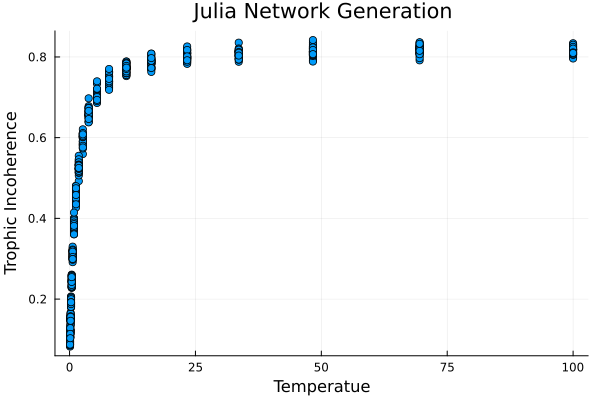

In [50]:
using Plots

plot(T_list,F_list, seriestype = :scatter, legend = false, xlabel= "Temperatue",

ylabel="Trophic Incoherence", title= "Julia Network Generation")

#savefig("Julia_generation_log_space.pdf")

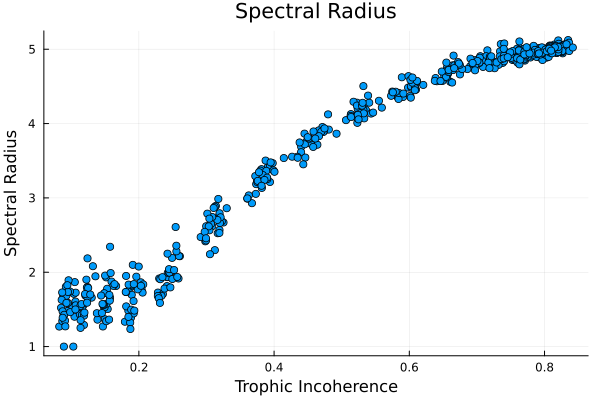

In [51]:
#println(eig_list)

plot(F_list, eig_list, seriestype = :scatter, legend = false, xlabel= "Trophic Incoherence",

ylabel="Spectral Radius", title= "Spectral Radius")


#savefig("Julia_generation_Spec_radius_logspace_2.pdf")

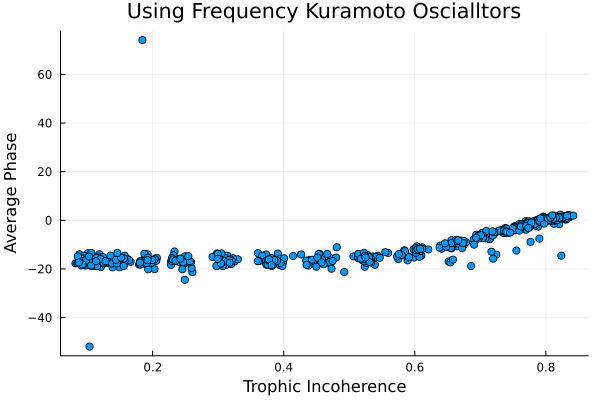

In [52]:
plot(F_list, (phase_list), seriestype = :scatter, legend = false, xlabel= "Trophic Incoherence",

ylabel="Average Phase", title= "Using Frequency Kuramoto Oscialltors")

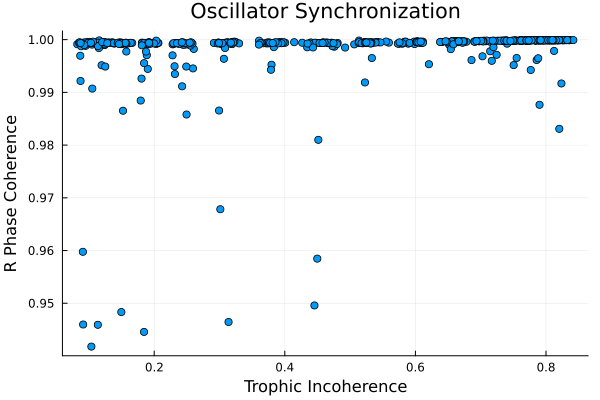

In [53]:
plot(F_list, r_list, seriestype = :scatter, legend = false, xlabel= "Trophic Incoherence",

ylabel="R Phase Coherence", title= "Oscillator Synchronization")


#savefig("Oscillator_Omega_equals_h_degree.pdf")

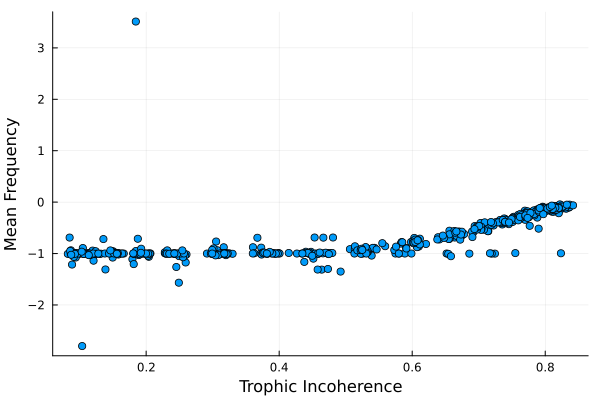

In [54]:
plot(F_list, (freq_mean), seriestype = :scatter, legend = false, xlabel= "Trophic Incoherence",

ylabel="Mean Frequency")


#savefig("outliers_1.pdf")

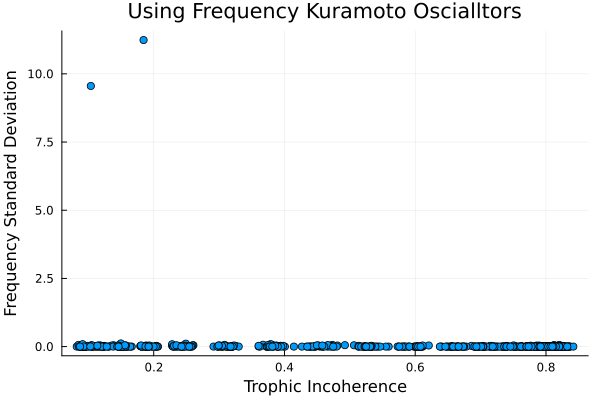

In [55]:
plot(F_list, (freq_sd), seriestype = :scatter, legend = false, xlabel= "Trophic Incoherence",

ylabel="Frequency Standard Deviation", title= "Using Frequency Kuramoto Oscialltors")

In [56]:
F_org= copy(F_list)

T_org= copy(T_list)

S_freq= copy(freq_mean)

S_sd= copy(freq_sd)

600-element Vector{Float64}:
 0.0010364095036730797
 0.00020719975805258474
 0.039696322837797504
 0.039729666792476
 0.049213544957775815
 0.0005230468954639509
 0.00024807376462869057
 0.0004805692230385811
 0.0002830557034673692
 0.0006913352565467713
 0.00014357359096694503
 4.5683713777525464e-5
 3.4499301933069234e-5
 ⋮
 4.4690055828292e-5
 0.00018679448134937396
 0.00010415240025980112
 4.237012799212238e-5
 4.3188800556278855e-5
 5.1725643497706276e-5
 4.323236023855043e-5
 2.058285900534626e-5
 9.857267841333558e-5
 4.688287761756117e-6
 4.015892666349512e-5
 4.085307878352186e-5

In [57]:


using Statistics

T_list=(reshape(T_list,(segments,instances)))

F_list=(reshape(F_list,(segments,instances)))

S_list_freq=(reshape(freq_mean,(segments,instances)))

S_list_sd= (reshape(freq_sd,(segments,instances)))


F_mean =zeros(segments)
F_error =zeros(segments)

S_mean_freq= zeros(segments)

S_error_freq= zeros(segments)

T_mean = zeros(segments)

#print(T_list[1,:])

println(S_list_sd)

for a in 1:segments
    
    loc= findall(<(1), S_list_sd[a,:])
    
    
    
    F_mean[a] = mean(F_list[a,:][loc])
    
    F_error[a] = std(F_list[a,:][loc])
    
    T_mean[a] = mean(T_list[a,:][loc])
    
    S_mean_freq[a] = mean(S_list_freq[a,:][loc])
    
    S_error_freq[a] = std(S_list_freq[a,:][loc])
    
    end 

[0.0010364095036730797 0.0003261960894119225 0.00012324094682485964 0.00029560648821323656 0.06275727160534668 0.00023244833619545378 0.039800901814810656 0.00012221952230879072 9.555395115526354 0.00019611191132573624 6.920928745290274e-5 0.0003861398190118068 3.1041104587139916e-5 0.0008701543841297469 0.02817688295768795 0.0057922371363810544 0.0001650775353367773 0.000386206356236921 0.00017283650756325428 0.0018575492606618357 0.00289383083563941 8.065998553209478e-5 0.00313252926833017 0.00010500198235593589 0.08880516346344045 0.0008653146554057978 8.993975652746901e-5 0.0038199066363044675 0.039743129408848596 0.000966114361260069; 0.00020719975805258474 0.02757990422236981 0.028111142803875982 0.0007312073356493114 0.00014069803335606476 0.0018179785927548925 0.00013450920515506023 0.03969923066883551 0.00034035232025490754 0.04872900391310522 0.0002409831264563055 0.0003789919501129143 0.002004192057914969 0.00039828163473184033 0.0005588933660734116 0.003323255346261979 0.03

 2.1910338520653704e-5 4.2132100624726734e-5 3.125737131422491e-5 0.00012158452538128886 1.0776799455651252e-5 0.058583421399089786 5.134110262919535e-5 1.5919483256462165e-5 4.519910101198206e-8 8.100660678902218e-5 1.0264625340519257e-5 6.324756845069606e-5 6.537280372351255e-5 1.1077690700651803e-5 6.451366719706594e-5 0.0005330232861394932 1.7632721412077293e-5 1.0558981902562967e-5 3.9924148502915876e-5 2.5244125205364554e-5 2.892257286882067e-5 4.688287761756117e-6; 1.4279875612982757e-5 4.148171468822653e-5 5.764522464830449e-5 2.3303047295621582e-5 1.0250110999764605e-5 6.775050619494823e-5 4.4354790617528656e-5 9.520868489177444e-5 4.32830021895845e-5 7.38402303237297e-5 3.436403863308969e-5 4.10348545100843e-5 5.408044412735172e-5 9.877187368376176e-6 3.0392197658615515e-5 5.339170809583372e-5 7.592487139224624e-6 4.4754432972586587e-7 2.362078763955732e-5 6.320102912924595e-6 3.2895069029437217e-7 2.3349782446970682e-5 0.00014115913173874277 1.8167390898003305e-5 8.055791889

number removed
2


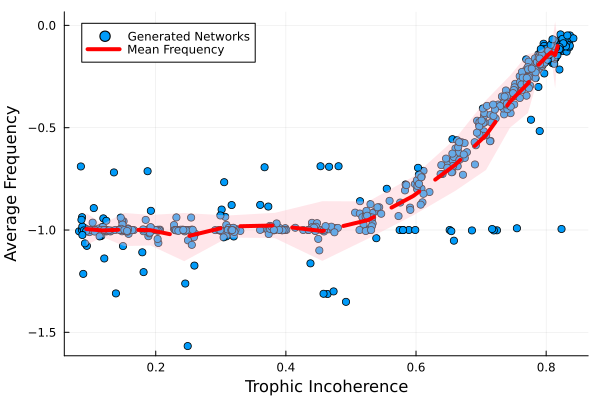

In [61]:
loc= findall(<(1), freq_sd)

println("number removed")

println( segments*instances -size(loc)[1])
plot(F_org[loc], S_freq[loc], seriestype = :scatter, legend = false, xlabel= "Trophic Incoherence",

ylabel="Average Frequency", ; label="Generated Networks")

plot!(F_mean,S_mean_freq, lw=4,   line=:red, ls=:dash, fillalpha=.4, c=:pink,ribbon=S_error_freq, label="Mean Frequency", legend = :true)


#savefig("final_Kuramotot_40_percent.pdf")

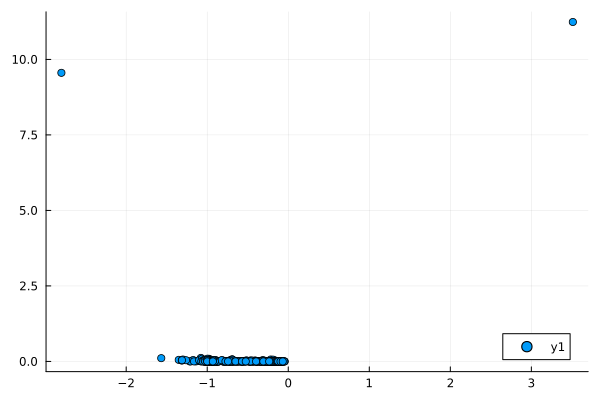

In [59]:
plot(freq_mean, freq_sd, seriestype = :scatter)

In [ ]:
plot(F_list, (phase_list), seriestype = :scatter, legend = false, xlabel= "Trophic Incoherence",

ylabel="Average Phase", title= "Using Frequency Kuramoto Oscialltors")

#savefig("Frequency_change_test_no_sign_40_percent.pdf")


In [ ]:
plot(F_list, cos.(phase_list), seriestype = :scatter, legend = false, xlabel= "Trophic Incoherence",

ylabel="Cosine of Average Phase", title= "Kuramoto Oscialltors")

#savefig("Mean_degree_generated_Kuramtoto_N_100_GRS3.pdf")

In [ ]:
plot(F_list, sin.(phase_list), seriestype = :scatter, legend = false, xlabel= "Trophic Incoherence",

ylabel="Sine of Average Phase", title= "Kuramoto Oscialltors")

In [ ]:
F_org= copy(F_list)

T_org= copy(T_list)

S_org= copy(cos.(phase_list))

In [ ]:
using Statistics

T_list=(reshape(T_list,(segments,instances)))

F_list=(reshape(F_list,(segments,instances)))

S_list=(reshape(cos.(phase_list),(segments,instances)))


F_mean =zeros(segments)
F_error =zeros(segments)

S_mean= zeros(segments)

S_error= zeros(segments)

T_mean = zeros(segments)

print(T_list[1,:])

for a in 1:segments
    
    print(T_list[a,:])
    
    F_mean[a] = mean(F_list[a,:])
    
    F_error[a] = std(F_list[a,:])
    
    T_mean[a] = mean(T_list[a,:])
    
    S_mean[a] = mean(S_list[a,:])
    
    S_error[a] = std(S_list[a,:])
    
    end 

In [ ]:
plot(F_org, S_org, seriestype = :scatter, legend = false, xlabel= "Trophic Incoherence",

ylabel="Cosine of Average Phase", title= "Kuramoto Oscillators", ; label="Generated Networks")

plot!(F_mean,S_mean, lw=4,   line=:red, ls=:dash, fillalpha=.4, c=:pink,ribbon=S_error, label="Cosine of Mean Phase", legend = :true)


#savefig("Pi_over_2_test.pdf")

In [ ]:
plot(F_mean, S_mean, seriestype = :scatter, legend = false, xlabel= "Trophic Incoherence",

ylabel="Cosine of Average Phase", yerror = S_error, error=F_error, title= "Kuramoto Oscillators")

#savefig("Kuramto_standard_error_N_500_K_5_30_repeats.pdf")

In [ ]:
plot(F_org, S_org, seriestype = :scatter, legend = false, xlabel= "Trophic Incoherence",

ylabel="Cosine of Average Phase", title= "Kuramoto Oscillators", ; label="Generated Networks")

plot!(F_mean,S_mean, lw=4,   line=:red, ls=:dash, fillalpha=.4, c=:pink,ribbon=S_error, label="Cosine of Mean Phase", legend = :true)


#savefig("Pi_over_2_test.pdf")

In [ ]:
F_org= copy(F_list)

T_org= copy(T_list)

S_org_sin= copy(sin.(phase_list))


using Statistics

T_list=(reshape(T_list,(segments,instances)))

F_list=(reshape(F_list,(segments,instances)))

S_list_sin=(reshape(sin.(phase_list),(segments,instances)))


F_mean =zeros(segments)
F_error =zeros(segments)

S_mean_sin= zeros(segments)

S_error_sin= zeros(segments)

T_mean = zeros(segments)

print(T_list[1,:])

for a in 1:segments
    
    print(T_list[a,:])
    
    F_mean[a] = mean(F_list[a,:])
    
    F_error[a] = std(F_list[a,:])
    
    T_mean[a] = mean(T_list[a,:])
    
    S_mean_sin[a] = mean(S_list_sin[a,:])
    
    S_error_sin[a] = std(S_list_sin[a,:])
    
    end 

In [ ]:
plot(F_org, S_org_sin, seriestype = :scatter, legend = false, xlabel= "Trophic Incoherence",

ylabel="Sine of Average Phase", title= "Kuramoto Oscillators", ; label="Generated Networks")

plot!(F_mean,S_mean_sin, lw=4,   line=:red, ls=:dash, fillalpha=.4, c=:pink,ribbon=S_error, label="Sine of Mean Phase", legend = :true)

In [ ]:
plot(T_mean,F_mean, seriestype = :scatter, legend = false, xlabel= "Temperatue",

ylabel="Trophic Incoherence", title= "Julia Network Generation", xaxis=:log, yerror= F_error)

In [ ]:
plot(eig_list, r_list, seriestype = :scatter, legend = false, xlabel= "Spectral Radius",

ylabel="R Phase Coherence", title= "Oscillator Synchronization Spectral Radius")

In [ ]:
sin(-pi)

In [ ]:
F_list[1,:][loc]

